In [23]:
import numpy as np
import os
import json

In [24]:
from filtool_script import FiltoolExec

In [25]:
fil_exec = FiltoolExec('/home/rsenzel/Code/inception/dev_injector/fb/controlfb2_uhf.fil', 'mmgps_search.json', 'test_dir', 1)

In [26]:
def slices(csv):
    for value in csv.split(","):
        if ":" not in value:
            yield float(value)
        else:
            x = value.split(":")
            start = float(x[0])
            end = float(x[1])
            if len(x) > 2:
                step = float(x[2])
            else:
                step = 1
            for subvalue in np.arange(start, end, step):
                yield subvalue

In [27]:
ddplan = fil_exec.create_DDplan()
for dm_range in ddplan:
    dm_csv = f"{dm_range.low_dm}:{dm_range.high_dm}:{dm_range.dm_step}"
    dm_list = sorted(list(set(list(slices(dm_csv)))))
    np.savetxt(f'outfile_{dm_range.tscrunch}.txt', dm_list, fmt='%.3f')

In [142]:
import xml.etree.ElementTree as ET
import json
import numpy as np

In [143]:
with open('/home/rsenzel/Code/inception/offline_injector_nextflow/xml_files/injection_report_inj_000001.json', 'r') as file:
    pars = json.load(file)

psr = pars['pulsars']

In [144]:
def xml_to_dict(element):
    # Convert element attributes and text to a dictionary
    data = {element.tag: {} if element.attrib else None}
    children = list(element)
    
    # Process each child
    if children:
        dd = {}
        for dc in map(xml_to_dict, children):
            for k, v in dc.items():
                if k in dd:
                    if not isinstance(dd[k], list):
                        dd[k] = [dd[k]]
                    dd[k].append(v)
                else:
                    dd[k] = v
        data = {element.tag: dd}
    if element.attrib:
        data[element.tag].update(('@' + k, v) for k, v in element.attrib.items())
    if element.text:
        text = element.text.strip()
        if children or element.attrib:
            if text:
                data[element.tag]['#text'] = text
        else:
            data[element.tag] = text
    return data

In [145]:
con1 = xml_to_dict(ET.parse('xml_files/con_1.xml').getroot())['peasoup_search']['candidates']['candidate']
con2 = xml_to_dict(ET.parse('xml_files/con_2.xml').getroot())['peasoup_search']['candidates']['candidate']
con3 = xml_to_dict(ET.parse('xml_files/con_3.xml').getroot())['peasoup_search']['candidates']['candidate']
con4 = xml_to_dict(ET.parse('xml_files/con_4.xml').getroot())['peasoup_search']['candidates']['candidate']

inj1 = xml_to_dict(ET.parse('xml_files/inj_1.xml').getroot())['peasoup_search']['candidates']['candidate']
inj2 = xml_to_dict(ET.parse('xml_files/inj_2.xml').getroot())['peasoup_search']['candidates']['candidate']
inj3 = xml_to_dict(ET.parse('xml_files/inj_3.xml').getroot())['peasoup_search']['candidates']['candidate']
inj4 = xml_to_dict(ET.parse('xml_files/inj_4.xml').getroot())['peasoup_search']['candidates']['candidate']

orig1 = xml_to_dict(ET.parse('xml_files/orig_1.xml').getroot())['peasoup_search']['candidates']['candidate']
orig2 = xml_to_dict(ET.parse('xml_files/orig_2.xml').getroot())['peasoup_search']['candidates']['candidate']
orig3 = xml_to_dict(ET.parse('xml_files/orig_3.xml').getroot())['peasoup_search']['candidates']['candidate']
orig4 = xml_to_dict(ET.parse('xml_files/orig_4.xml').getroot())['peasoup_search']['candidates']['candidate']

# nm1 = xml_to_dict(ET.parse('xml_files/no_merge_1.xml').getroot())['peasoup_search']['candidates']['candidate']
# nm2 = xml_to_dict(ET.parse('xml_files/no_merge_2.xml').getroot())['peasoup_search']['candidates']['candidate']
# nm3 = xml_to_dict(ET.parse('xml_files/no_merge_3.xml').getroot())['peasoup_search']['candidates']['candidate']
# nm4 = xml_to_dict(ET.parse('xml_files/no_merge_4.xml').getroot())['peasoup_search']['candidates']['candidate']

con = [*con1, *con2, *con3, *con4]
inj = [*inj1, *inj2, *inj3, *inj4]
orig = [*orig1, *orig2, *orig3, *orig4]
# nm = [*nm1, *nm2, *nm3, *nm4]

len(con), len(orig),  len(inj) #len(nm),

(803, 803, 806)

In [34]:
class CandidateXMLMatcher:
    def __init__(self, injected_pulsars, injected_xml, original_xml):
        self.injected_xml = self.get_cands(injected_xml)
        self.original_xml = self.get_cands(original_xml)
        self.psr = self.get_pulsars(injected_pulsars)

    def get_cands(self, xml):
        return self.xml_to_dict(ET.parse(xml).getroot())['peasoup_search']['candidates']['candidate']
    
    def get_pulsars(self, psr_file):
        with open(psr_file, 'r') as file:
            pars = json.load(file)
        return pars['pulsars']
    
    @staticmethod
    def xml_to_dict(element):
        data = {element.tag: {} if element.attrib else None}
        children = list(element)
        
        if children:
            dd = {}
            for dc in map(xml_to_dict, children):
                for k, v in dc.items():
                    if k in dd:
                        if not isinstance(dd[k], list):
                            dd[k] = [dd[k]]
                        dd[k].append(v)
                    else:
                        dd[k] = v
            data = {element.tag: dd}
        if element.attrib:
            data[element.tag].update(('@' + k, v) for k, v in element.attrib.items())
        if element.text:
            text = element.text.strip()
            if children or element.attrib:
                if text:
                    data[element.tag]['#text'] = text
            else:
                data[element.tag] = text
        return data

In [146]:
def condition(key, tol, cand1, cand2):
    lower = (float(cand1[key]) >= float(cand2[key])*(1-tol)) 
    upper = (float(cand1[key]) <= float(cand2[key])*(1+tol)) 
    return lower and upper

def get_diffs(inj_cand, orig_cand):
    period_diff = float(inj_cand['period'])-float(orig_cand['period'])
    dm_diff = float(inj_cand['dm'])-float(orig_cand['dm'])
    acc_diff = float(inj_cand['acc'])-float(orig_cand['acc'])
    snr_diff = float(inj_cand['snr'])-float(orig_cand['snr'])
    return period_diff, dm_diff, acc_diff, snr_diff

def get_cand_match(original, injected, tol):
    cand_match = []
    for i, inj_cand in enumerate(injected):
        for j, orig_cand in enumerate(original):
            condition1 = condition('period', tol, inj_cand, orig_cand)
            condition2 = condition('dm', tol, inj_cand, orig_cand)
            condition3 = condition('acc', tol, inj_cand, orig_cand)
            if condition1 and condition2 and condition3:
                cand_match.append([i, j, *get_diffs(inj_cand, orig_cand)])
                break
    return np.array(cand_match)

def remove_cands(cands1, cands2, cand_match):
    cands1c = cands1.copy()
    cands2c = cands2.copy()

    ind1 = cand_match.T[0].astype(int)
    ind2 = cand_match.T[1].astype(int)
    for index in sorted(ind1, reverse=True):
        del cands1c[index]
    for index in sorted(ind2, reverse=True):
        del cands2c[index]
    return cands1c, cands2c

In [147]:
cand_match1 = get_cand_match(orig1, con1, tol=0)
cand_match2 = get_cand_match(orig2, con2, tol=0)
cand_match3 = get_cand_match(orig3, con3, tol=0)
cand_match4 = get_cand_match(orig4, con4, tol=0)
[[len(cand_match1), len(con1), len(orig1)],
 [len(cand_match2), len(con2), len(orig2)],
 [len(cand_match3), len(con3), len(orig3)],
 [len(cand_match4), len(con4), len(orig4)]]

[[525, 525, 525], [151, 151, 151], [104, 104, 104], [23, 23, 23]]

In [37]:
nc1, no1 = remove_cands(con1, orig1, cand_match1)
nc2, no2 = remove_cands(con2, orig2, cand_match2)

In [38]:
cm1 = get_cand_match(no1, nc1, tol=0.01)
cm2 = get_cand_match(no2, nc2, tol=0.01)
len(cm1), len(cm2)

(0, 0)

In [39]:
cm1 = get_cand_match(no1, nc1, tol=0.1)
cm2 = get_cand_match(no2, nc2, tol=0.1)
len(cm1), len(cm2)

(0, 0)

In [40]:
cm1 = get_cand_match(no1, nc1, tol=0.5)
cm2 = get_cand_match(no2, nc2, tol=0.5)
len(cm1), len(cm2)

(0, 0)

In [148]:
import pandas as pd

In [149]:
inj_c = pd.read_csv('xml_files/inj_good_cands_to_fold_with_beam.csv', index_col=0)
con_c = pd.read_csv('xml_files/con_good_cands_to_fold_with_beam.csv', index_col=0)
orig_c = pd.read_csv('xml_files/6046200_good_cands_to_fold_with_beam.csv', index_col=0)
len(inj_c), len(orig_c), len(con_c),  np.sum(con_c['snr']-orig_c['snr'])

(23566, 23560, 23560, np.float64(0.0))

In [150]:
con_c['beam_id'].value_counts().head(15)

beam_id
cfbf00097    563
cfbf00104    508
cfbf00105    503
cfbf00151    134
cfbf00079     89
cfbf00076     86
cfbf00080     81
cfbf00078     81
cfbf00077     79
cfbf00312     71
cfbf00229     68
cfbf00072     68
cfbf00408     68
cfbf00075     67
cfbf00087     66
Name: count, dtype: int64

In [151]:
inj_p0 = [psr_i['PX'][0] for psr_i in psr]
inj_dm = [psr_i['DM'] for psr_i in psr]
inj_snr = [round(psr_i['SNR'], 5) for psr_i in psr]
inj_bin = [psr_i['binary_period'] for psr_i in psr]
list(zip(inj_p0, inj_dm, inj_snr, inj_bin))

[(2.119481126264242, 89.38349026324208, 13.45509, None),
 (0.02033142050659543, 334.9673500263703, 29.33122, 11513.124734778808),
 (0.006310689271586747, 95.64797204949794, 13.86007, 6741.748742748116),
 (0.029860443236433526, 497.61791041498606, 39.84601, 14755.933509768929),
 (0.003299254582649314, 44.24589718660036, 10.53711, 5716.9314963774705),
 (0.005696684430317391, 85.16754458645202, 13.18255, 6532.797589665021),
 (0.021825437688184793, 360.46867778108526, 30.97979, 12021.551691435498),
 (0.01423765451349229, 230.95306841995458, 22.60707, 9439.363511259613),
 (0.0015585260986010706, 14.533462717501033, 8.6163, 5124.546551668371),
 (0.02690584124480148, 447.185910902646, 36.58576, 13750.456921381103)]

In [153]:
inj_c.head()

,Unnamed: 0,level_0,index,period,opt_period,dm,acc,nh,snr,folded_snr,...,src_rajd,src_dej,src_dejd,file_index,file,cluster_id,strongest_in_cluster,spatial_rfi,low_nassoc,beam_id
0,0,0,5,0.742323,0,166.899994,44.238869,4,48.633198,0,...,184.491250,-702109.7,-70.352694,1917,/tmp/rsenzel/data_000001_inj_000001_overview_d...,0,1,0,0,cfbf00349
1,2,2,20,0.741983,0,159.649994,-105.000000,1,26.260859,0,...,184.491250,-702109.7,-70.352694,1917,/tmp/rsenzel/data_000001_inj_000001_overview_d...,1,1,0,0,cfbf00349
2,4,4,24,0.033679,0,120.099998,-20.106552,0,23.754232,0,...,182.386333,-702015.9,-70.337750,421,/hercules/scratch/vishnu/MMGPS_UHF_DATA/MMGPS_...,2,1,0,0,cfbf00105
3,5,6,26,2.226561,0,167.050003,25.687378,4,22.785351,0,...,184.491250,-702109.7,-70.352694,1917,/tmp/rsenzel/data_000001_inj_000001_overview_d...,3,1,0,0,cfbf00349
4,7,8,34,0.026985,0,446.299988,105.000000,0,20.511885,0,...,184.491250,-702109.7,-70.352694,1919,/tmp/rsenzel/data_000001_inj_000001_overview_d...,4,1,0,0,cfbf00349


In [211]:
pulsar_cands = [[] for _ in range(len(psr))]
ptol, dmtol = 0.01, 0.01
for i, psr_i in enumerate(psr):
    p0_i = psr_i['PX'][0]
    dm_i = psr_i['DM']
    p_cond = (inj_c['period'] > p0_i*(1-ptol)) & (inj_c['period'] < p0_i*(1+ptol))
    dm_cond = (inj_c['dm'] > dm_i*(1-dmtol)) & (inj_c['dm'] < dm_i*(1+dmtol))
    psr_cands = inj_c[p_cond & dm_cond]
    pulsar_cands[i].extend(psr_cands.index.values)

In [212]:
cand_len = [len(psr_c) for psr_c in pulsar_cands]
cand_len, np.sum(cand_len)

([0, 2, 4, 1, 1, 2, 1, 2, 4, 1], np.int64(18))

In [202]:
cand_len = [len(psr_c) for psr_c in pulsar_cands]
cand_len, np.sum(cand_len)

([0, 2, 15, 2, 16, 14, 2, 2, 12, 1], np.int64(66))

In [197]:
cand_len = [len(psr_c) for psr_c in pulsar_cands]
cand_len, np.sum(cand_len)

([0, 3, 31, 3, 44, 36, 4, 6, 24, 2], np.int64(153))

(0.0, 0.1)

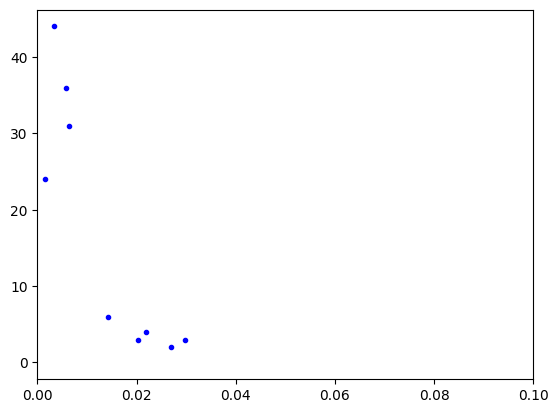

In [196]:
plt.plot(inj_p0, cand_len, 'b.')
plt.xlim([0, 0.1])

[0, 3, 31, 3, 44, 36, 4, 6, 24, 2]

In [186]:
pulsar_cands

[[np.int64(4), np.int64(7176)], [], [], [], [], [], [], [], [], []]

array([   4, 7176])